In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

from google.colab import files
uploaded = files.upload()

# If your file is named differently, update the filename below
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Standardize column names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# Convert target to binary {0,1}
df['Churn'] = (df['Churn'].str.strip().str.lower() == 'yes').astype(int)

# Known issue: TotalCharges sometimes blank -> coerce to numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop duplicate customer IDs if any
id_col = 'customerID' if 'customerID' in df.columns else None
if id_col and df[id_col].duplicated().any():
    df = df.sort_values(by=[id_col]).drop_duplicates(subset=[id_col], keep='last')

print("Shape:", df.shape)
df.head()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [3]:
def show_segment_churn(data, feature):
    tmp = data.groupby(feature)['Churn'].agg(['count', 'mean']).rename(columns={'mean':'churn_rate'})
    display(tmp.sort_values('churn_rate', ascending=False))

for feat in ['Contract', 'PaymentMethod', 'InternetService']:
    if feat in df.columns:
        print(f"\n=== Churn by {feat} ===")
        show_segment_churn(df, feat)

# Tenure & charges lenses
if 'MonthlyCharges' in df.columns:
    df['high_charge_flag'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)
    print("\n=== Churn by high_charge_flag ===")
    show_segment_churn(df, 'high_charge_flag')

if 'tenure' in df.columns:
    bins = [0, 12, 24, 60, df['tenure'].max()+1]
    labels = ['0-12','13-24','25-60','60+']
    df['tenure_bucket'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)
    print("\n=== Churn by tenure_bucket ===")
    show_segment_churn(df, 'tenure_bucket')


=== Churn by Contract ===


,count,churn_rate
Contract,,
Month-to-month,3875,0.427097
One year,1473,0.112695
Two year,1695,0.028319



=== Churn by PaymentMethod ===


,count,churn_rate
PaymentMethod,,
Electronic check,2365,0.452854
Mailed check,1612,0.191067
Bank transfer (automatic),1544,0.167098
Credit card (automatic),1522,0.152431



=== Churn by InternetService ===


,count,churn_rate
InternetService,,
Fiber optic,3096,0.418928
DSL,2421,0.189591
No,1526,0.074050



=== Churn by high_charge_flag ===


,count,churn_rate
high_charge_flag,,
1,3515,0.351920
0,3528,0.179138



=== Churn by tenure_bucket ===


,count,churn_rate
tenure_bucket,,
0-12,2069,0.482842
13-24,1047,0.295129
25-60,2444,0.189034
60+,1483,0.066757


In [4]:
# =========================
# 3) Train/Val/Test split
# =========================
target = 'Churn'
X = df.drop(columns=[target])
y = df[target].values

# Keep ID aside if present
id_col = 'customerID' if 'customerID' in df.columns else None
X_ids = X[id_col] if (id_col and id_col in X.columns) else None
if id_col and id_col in X.columns:
    X = X.drop(columns=[id_col])

from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=SEED
)  # 0.25 of 0.8 = 0.2

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)
print("Churn rate overall:", y.mean().round(3))


Train: (4225, 21)  Val: (1409, 21)  Test: (1409, 21)
Churn rate overall: 0.265


In [5]:
# =========================
# 4) Preprocessing (fixed for sklearn >=1.2)
# =========================
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # safe with sparse matrices
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop',
    sparse_threshold=1.0
)


In [6]:
# =========================
# 5) Models (no LightGBM)
# =========================
# A) Interpretable: Logistic Regression (Elastic Net)
log_reg = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(
        penalty='elasticnet', l1_ratio=0.3, solver='saga',
        class_weight='balanced', max_iter=5000, random_state=SEED
    ))
])

# B) Nonlinear: Random Forest
rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=5,
        n_jobs=-1, class_weight='balanced_subsample', random_state=SEED
    ))
])

# C) Optional: LinearSVC with calibrated probabilities
svc_raw = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LinearSVC(C=1.0, class_weight='balanced', random_state=SEED))
])
svc = CalibratedClassifierCV(svc_raw, cv=5, method='sigmoid')


[LogReg] Val ROC-AUC: 0.837 | PR-AUC: 0.642
[RandomForest] Val ROC-AUC: 0.834 | PR-AUC: 0.629
[CalibratedSVC] Val ROC-AUC: 0.837 | PR-AUC: 0.643


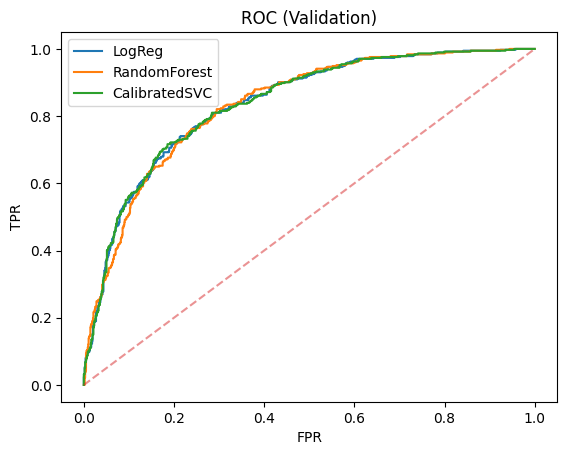

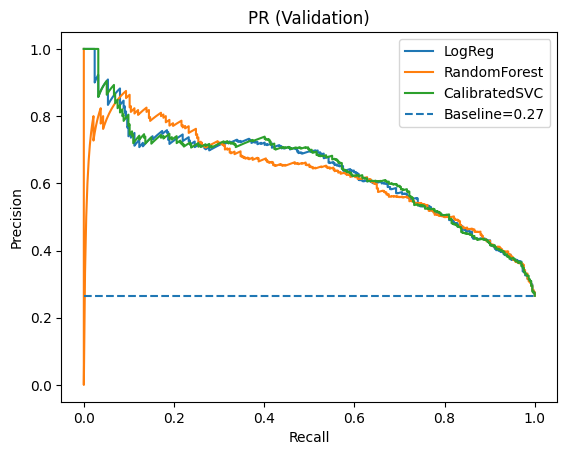

In [7]:
# =========================
# 6) Training & Validation
# =========================
def fit_and_eval(model, X_tr, y_tr, X_va, y_va, name="model"):
    model.fit(X_tr, y_tr)
    p_va = model.predict_proba(X_va)[:,1] if hasattr(model, "predict_proba") else None
    if p_va is None and hasattr(model, "decision_function"):
        from sklearn.preprocessing import MinMaxScaler
        p_va = MinMaxScaler().fit_transform(model.decision_function(X_va).reshape(-1,1)).ravel()
    roc = roc_auc_score(y_va, p_va)
    pr  = average_precision_score(y_va, p_va)
    print(f"[{name}] Val ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")
    return model, p_va

models = {}
for mdl, name in [(log_reg, "LogReg"), (rf, "RandomForest")]:
    m, p_va = fit_and_eval(mdl, X_train, y_train, X_val, y_val, name)
    models[name] = {'model': m, 'p_va': p_va}

# Optional SVC (can be slower)
try:
    m, p_va = fit_and_eval(svc, X_train, y_train, X_val, y_val, "CalibratedSVC")
    models["CalibratedSVC"] = {'model': m, 'p_va': p_va}
except Exception as e:
    print("SVC skipped:", e)

# ROC & PR plots
plt.figure()
for name, obj in models.items():
    fpr, tpr, _ = roc_curve(y_val, obj['p_va'])
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Validation)"); plt.legend(); plt.show()

plt.figure()
for name, obj in models.items():
    prec, rec, _ = precision_recall_curve(y_val, obj['p_va'])
    plt.plot(rec, prec, label=name)
baseline = y_val.mean()
plt.hlines(baseline, 0, 1, linestyles='--', label=f"Baseline={baseline:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (Validation)"); plt.legend(); plt.show()


In [8]:
# =========================
# 7) Cost-based thresholding
# =========================
C_offer = 10.0   # cost of retention offer
R_save  = 80.0   # revenue saved when a churner is correctly targeted
R_lost  = 200.0  # revenue lost if a churner is missed

def expected_value(y_true, p, thr):
    y_pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ev = tp*R_save - (tp+fp)*C_offer - fn*R_lost
    prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
    return ev, prec, rec, (tn, fp, fn, tp)

def sweep_thresholds(y_true, p, name="model"):
    thrs = np.linspace(0.05, 0.95, 19)
    out = []
    for t in thrs:
        ev, prec, rec, (tn, fp, fn, tp) = expected_value(y_true, p, t)
        out.append((t, ev, prec, rec, tp, fp, fn, tn))
    out = pd.DataFrame(out, columns=['threshold','EV','precision','recall','TP','FP','FN','TN'])
    print(f"\nTop thresholds by EV — {name}")
    display(out.sort_values('EV', ascending=False).head(3))
    return out

best_name = max(models.keys(), key=lambda k: average_precision_score(y_val, models[k]['p_va']))
thr_table = sweep_thresholds(y_val, models[best_name]['p_va'], name=best_name)
best_thr = float(thr_table.sort_values('EV', ascending=False).iloc[0]['threshold'])
print("Chosen threshold:", round(best_thr, 2), "| Best model:", best_name)



Top thresholds by EV — CalibratedSVC


,threshold,EV,precision,recall,TP,FP,FN,TN
0,0.05,16730.0,0.350337,0.973262,364,675,10,360
1,0.10,13850.0,0.395904,0.930481,348,531,26,504
2,0.15,11220.0,0.430591,0.895722,335,443,39,592


Chosen threshold: 0.05 | Best model: CalibratedSVC


In [9]:
# =========================
# 8) Final Test evaluation
# =========================
best_model = models[best_name]['model']
best_model.fit(pd.concat([X_train, X_val]), np.concatenate([y_train, y_val]))

p_test = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None
roc = roc_auc_score(y_test, p_test)
pr  = average_precision_score(y_test, p_test)
ev, prec, rec, cm = expected_value(y_test, p_test, best_thr)
tn, fp, fn, tp = cm

print(f"\n[TEST] {best_name} ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")
print(f"[TEST] EV={ev:.1f} at threshold={best_thr:.2f} | Precision={prec:.2f} | Recall={rec:.2f}")
print("Confusion matrix [TN, FP; FN, TP]:")
print(np.array([[tn, fp],[fn, tp]]))
print("Brier score:", brier_score_loss(y_test, p_test).round(4))



[TEST] CalibratedSVC ROC-AUC: 0.839 | PR-AUC: 0.623
[TEST] EV=18330.0 at threshold=0.05 | Precision=0.35 | Recall=0.99
Confusion matrix [TN, FP; FN, TP]:
[[358 677]
 [  4 370]]
Brier score: 0.1394


In [11]:
# =========================
# 9) Explainability (robust to CalibratedClassifierCV)
# =========================


def extract_preprocessor_from_model(model, fallback=None):
    """Return the fitted 'prep' preprocessor from a Pipeline or from inside CalibratedClassifierCV, else fallback."""
    # Direct pipeline
    if hasattr(model, 'named_steps'):
        return model.named_steps.get('prep', fallback)
    # CalibratedClassifierCV (sklearn >=1.2 uses 'estimator'; older uses 'base_estimator')
    inner = getattr(model, 'estimator', None)
    if inner is None:
        inner = getattr(model, 'base_estimator', None)
    if inner is not None and hasattr(inner, 'named_steps'):
        return inner.named_steps.get('prep', fallback)
    return fallback

def get_feature_names_from_preprocessor(prep, numeric_features, categorical_features, X_fit=None, y_fit=None):
    """
    Return feature names from a fitted ColumnTransformer 'prep'.
    If it's not fitted yet (no categories_), fit a clone on X_fit to get names.
    """
    # If not fitted, categories_ won't exist on the OHE; fit a clone if X_fit provided.
    try:
        ohe = prep.named_transformers_['cat'].named_steps['onehot']
        _ = ohe.get_feature_names_out  # attribute exists
        # if it's not fitted, accessing categories_ will raise
        _ = ohe.categories_
        fitted_prep = prep
    except Exception:
        if X_fit is None:
            raise RuntimeError("Preprocessor not fitted and no X_fit provided to infer feature names.")
        fitted_prep = clone(prep).fit(X_fit, y_fit)
        ohe = fitted_prep.named_transformers_['cat'].named_steps['onehot']

    num_names = list(numeric_features)
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()
    return num_names + cat_names, fitted_prep

# Try to pull the fitted preprocessor from the best model; fall back to the global 'preprocess'
prep_fitted = extract_preprocessor_from_model(best_model, fallback=preprocess)

# Build feature names (fit a clone if needed)
feature_names, _ = get_feature_names_from_preprocessor(
    prep_fitted, numeric_features, categorical_features, X_fit=X_train, y_fit=y_train
)

# Permutation importance on validation (uses PR-AUC to match business goal)
perm = permutation_importance(
    best_model, X_val, y_val,
    n_repeats=10, random_state=SEED, n_jobs=-1, scoring='average_precision'
)
imp_df = (pd.DataFrame({
    'feature': feature_names[:len(perm.importances_mean)],  # guard against any mismatch
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
})
.sort_values('importance_mean', ascending=False))

print("\nTop features by permutation importance (Validation, PR-AUC):")
display(imp_df.head(20))

# PDP: pick a few likely-important features if present
cand_keys = ['MonthlyCharges','tenure','Contract_Month-to-month','PaymentMethod_Electronic_check']
cand_features = []
for key in cand_keys:
    matches = [f for f in feature_names if key in f]
    if matches:
        cand_features.append(matches[0])

if cand_features:
    try:
        PartialDependenceDisplay.from_estimator(best_model, X_val, features=cand_features, kind='average')
        plt.suptitle("Partial Dependence — key features")
        plt.show()
    except Exception as e:
        print("PDP skipped:", e)



Top features by permutation importance (Validation, PR-AUC):


,feature,importance_mean,importance_std
7,Partner_No,0.221604,0.018979
17,InternetService_Fiber optic,0.132313,0.015511
13,MultipleLines_No,0.065496,0.011121
14,MultipleLines_No phone service,0.050063,0.010524
12,PhoneService_Yes,0.045161,0.009198
4,high_charge_flag,0.043913,0.009098
6,gender_Male,0.031880,0.006591
20,OnlineSecurity_No internet service,0.028821,0.008365
5,gender_Female,0.019187,0.003678
10,Dependents_Yes,0.017730,0.006480


PDP skipped: Feature 'Contract_Month-to-month' not in feature_names


In [12]:
# Score whole dataset
p_all = best_model.predict_proba(X)[:,1] if hasattr(best_model, "predict_proba") else None

risk = pd.DataFrame({
    'customerID': X_ids if X_ids is not None else np.arange(len(X)),
    'churn_prob': p_all
})

# Risk bands (tweak cut points to your business)
risk['risk_band'] = pd.cut(
    risk['churn_prob'],
    bins=[-0.001, 0.2, 0.5, 1.0],
    labels=['Low','Medium','High']
)

display(risk.sort_values('churn_prob', ascending=False).head(10))
risk.to_csv("churn_risk_scored.csv", index=False)
print("Saved: churn_risk_scored.csv")


,customerID,churn_prob,risk_band
1976,9497-QCMMS,0.876679,High
4800,9300-AGZNL,0.874059,High
3749,4424-TKOPW,0.872854,High
6368,2720-WGKHP,0.872001,High
1410,7024-OHCCK,0.870745,High
3380,5178-LMXOP,0.869763,High
5989,5567-WSELE,0.868564,High
3159,5150-ITWWB,0.864479,High
997,1374-DMZUI,0.863443,High
2208,7216-EWTRS,0.862381,High


Saved: churn_risk_scored.csv


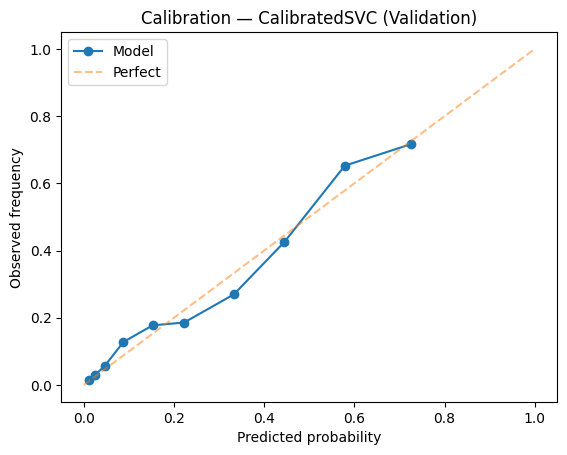

In [13]:
# =========================
# 11) Calibration curve
# =========================
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, models[best_name]['p_va'], n_bins=10, strategy='quantile')

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1],'--',alpha=0.5, label='Perfect')
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title(f"Calibration — {best_name} (Validation)")
plt.legend(); plt.show()


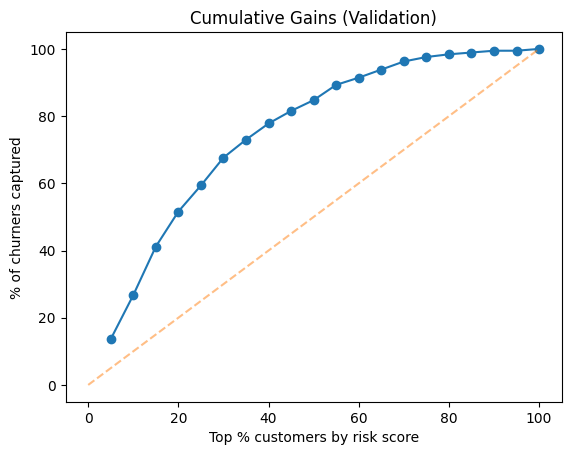

Top 10% contains 26.7% of churners
Top 20% contains 51.6% of churners


In [14]:
# =========================
# 12) Lift / Gains (Validation)
# =========================
val_scores = pd.DataFrame({'y': y_val, 'p': models[best_name]['p_va']}).sort_values('p', ascending=False).reset_index(drop=True)
val_scores['decile'] = pd.qcut(val_scores['p'], 10, labels=False, duplicates='drop')

# Cumulative capture by top k%
k_vals = np.arange(0.05, 1.05, 0.05)
tot_churners = val_scores['y'].sum()
captures = []
for k in k_vals:
    top_k = val_scores.iloc[:int(len(val_scores)*k)]
    captures.append(top_k['y'].sum()/tot_churners if tot_churners>0 else 0)

plt.figure()
plt.plot(k_vals*100, np.array(captures)*100, marker='o')
plt.plot([0,100],[0,100],'--', alpha=0.5)
plt.xlabel("Top % customers by risk score")
plt.ylabel("% of churners captured")
plt.title("Cumulative Gains (Validation)")
plt.show()

print(f"Top 10% contains {captures[int(0.10/0.05)-1]*100:.1f}% of churners")
print(f"Top 20% contains {captures[int(0.20/0.05)-1]*100:.1f}% of churners")


In [17]:
os.makedirs("artifacts", exist_ok=True)
joblib.dump(best_model, "artifacts/best_model.joblib")
meta = {
    "best_model_name": best_name,
    "threshold": float(best_thr),
    "metrics": {
        "val_pr_auc": float(average_precision_score(y_val, models[best_name]['p_va'])),
    },
    "numeric_features": list(numeric_features),
    "categorical_features": list(categorical_features)
}
with open("artifacts/metadata.json","w") as f:
    json.dump(meta, f, indent=2)

print("Saved: artifacts/best_model.joblib and artifacts/metadata.json")


Saved: artifacts/best_model.joblib and artifacts/metadata.json
